In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
import datetime
import scipy.stats as stats
from xgboost import plot_importance

from talib import RSI, BBANDS, MACD

In [2]:
input_df_mod1 = pd.read_csv('xg_mod1.csv',index_col=0)
input_df_mod2 = pd.read_csv('xg_mod2.csv',index_col=0)
"""
btc=pd.read_csv('btc.csv',index_col=0)
btc=btc[['btc_close','btc_volume']]
btc.astype(float)
"""

"\nbtc=pd.read_csv('btc.csv',index_col=0)\nbtc=btc[['btc_close','btc_volume']]\nbtc.astype(float)\n"

In [10]:
"""
btc.index,input_df_mod1.index,input_df_mod2.index=pd.to_datetime(btc.index),pd.to_datetime(input_df_mod1.index),pd.to_datetime(input_df_mod2.index)
input_df_mod1=input_df_mod1.join(btc)
input_df_mod2=input_df_mod2.join(btc)

"""

In [3]:
print(input_df_mod1.columns)
print(input_df_mod2.columns)

Index(['tiger_adjclose', 'tiger_volume', 'sp500_adjclose', 'sp500_volume',
       'sp500_f_adjclose', 'sp500_f_volume', 'sugar_close', 'sugar_volume',
       'soybean_close', 'soybean_volume', 'corn_close', 'corn_volume',
       'crude_oil_adjclose', 'crude_oil_volume', 'ethanol_close',
       'ethanol_volume', 'tbond_fut_adjclose', 'tbond_fut_volume',
       'DBA_adjclose', 'DBA_volume', 'CORN_adjclose', 'CORN_volume',
       'SOYB_adjclose', 'SOYB_volume', 'WEAT_volume', 'MOO_adjclose',
       'MOO_volume', 'tiger_metal_close', 'tiger_metal_volume',
       'tiger_oil_close', 'tiger_oil_volume', 'usd_f_close', 'usd_f_volume',
       'wheat_close', 'wheat_volume', 'sugar_close_mean', 'wheat_close_mean',
       'soybean_close_mean', 'corn_close_mean', 'crude_oil_adjclose_mean',
       'ethanol_close_mean', 'tbond_fut_adjclose_mean', 'DBA_adjclose_mean',
       'SOYB_adjclose_mean', 'WEAT_adjclose_mean', 'MOO_adjclose_mean',
       'usd_f_close_mean', 'tiger_metal_close_mean', 'tiger_oil

In [15]:
#input_df_mod1.drop(['sp500_adjclose_mean', 'sp500_f_adjclose_mean','CORN_adjclose','CORN_adjclose_mean'],axis=1,inplace=True)
# input_df_mod2.drop(['actual_growth','prev_growth','sp500_f_adjclose','CORN_adjclose_mean','growth_pred_error'],axis=1,inplace=True)

In [11]:
'''
정규화도 진행해보자.
'''

# time series에 대해 정규화를 하는게 맞는지 잘 모르겠다. 이것도 일단 실행 안함.

# 정규화 진행

# Scaling 할 컬럼명 저장
df1_cols = [x for x in input_df_mod1.columns]
df1_cols.remove('actual_growth')
df1_cols.remove('pred_growth')
df1_cols.remove('prev_growth')
df1_cols.remove('growth_pred_error')
#df1_cols.remove('growth_prev_resid')
df1_cols.remove('tiger_label')

df2_cols = [x for x in input_df_mod2.columns]
#df2_cols.remove('actual_growth')
df2_cols.remove('pred_growth')
df2_cols.remove('growth_pred_error')
#df2_cols.remove('growth_prev_resid')
#df2_cols.remove('prev_growth')
df2_cols.remove('kodex_label')

def std_scaling_tiger(df,cols):
    scaler = preprocessing.StandardScaler()
    normalized_data = scaler.fit_transform(df[cols])
    normalized_df = pd.DataFrame(normalized_data, columns=cols, index=df.index)
    return normalized_df.join(df[['actual_growth','pred_growth','prev_growth','growth_pred_error','tiger_label']])
    #return normalized_df.join(df[['actual_growth','pred_growth','prev_growth','growth_pred_error','growth_prev_resid','tiger_label']])

def std_scaling_kodex(df,cols):
    scaler = preprocessing.RobustScaler()
    normalized_data = scaler.fit_transform(df[cols])
    normalized_df = pd.DataFrame(normalized_data, columns=cols, index=df.index)
    return normalized_df.join(df[['pred_growth','kodex_label']])
    #return normalized_df.join(df[['pred_growth','growth_prev_resid','kodex_label']])

input_df_mod1 = std_scaling_tiger(input_df_mod1,df1_cols)
input_df_mod2 = std_scaling_kodex(input_df_mod2,df2_cols)

In [12]:
X_temp_mod1 = input_df_mod1[input_df_mod1.index <= '2020-07-01'].drop(['tiger_label'],axis=1)
y_temp_mod1 = input_df_mod1[input_df_mod1.index <= '2020-07-01'][['tiger_label']]
X_train_mod1, X_valid_mod1, y_train_mod1, y_valid_mod1 = train_test_split(X_temp_mod1, y_temp_mod1, test_size=0.1, random_state=42)
X_test_mod1 = input_df_mod1[input_df_mod1.index > '2020-07-01'].drop(['tiger_label'],axis=1)
y_test_mod1 = input_df_mod1[input_df_mod1.index > '2020-07-01'][['tiger_label']]

X_temp_mod2 = input_df_mod2[input_df_mod2.index <= '2020-12-31'].drop(['kodex_label'],axis=1)
y_temp_mod2 = input_df_mod2[input_df_mod2.index <= '2020-12-31'][['kodex_label']]
X_train_mod2, X_valid_mod2, y_train_mod2, y_valid_mod2 = train_test_split(X_temp_mod2, y_temp_mod2, test_size=0.1, random_state=42)
X_test_mod2 = input_df_mod2[input_df_mod2.index > '2020-12-31'].drop(['kodex_label'],axis=1)
y_test_mod2 = input_df_mod2[input_df_mod2.index > '2020-12-31'][['kodex_label']]


[0]	validation_0-error:0.50000


C:\Users\lsh\anaconda3\envs\ml4t\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lsh\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[38]	validation_0-error:0.47143
Model F1 Score :  0.6296296296296297


C:\Users\lsh\anaconda3\envs\ml4t\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

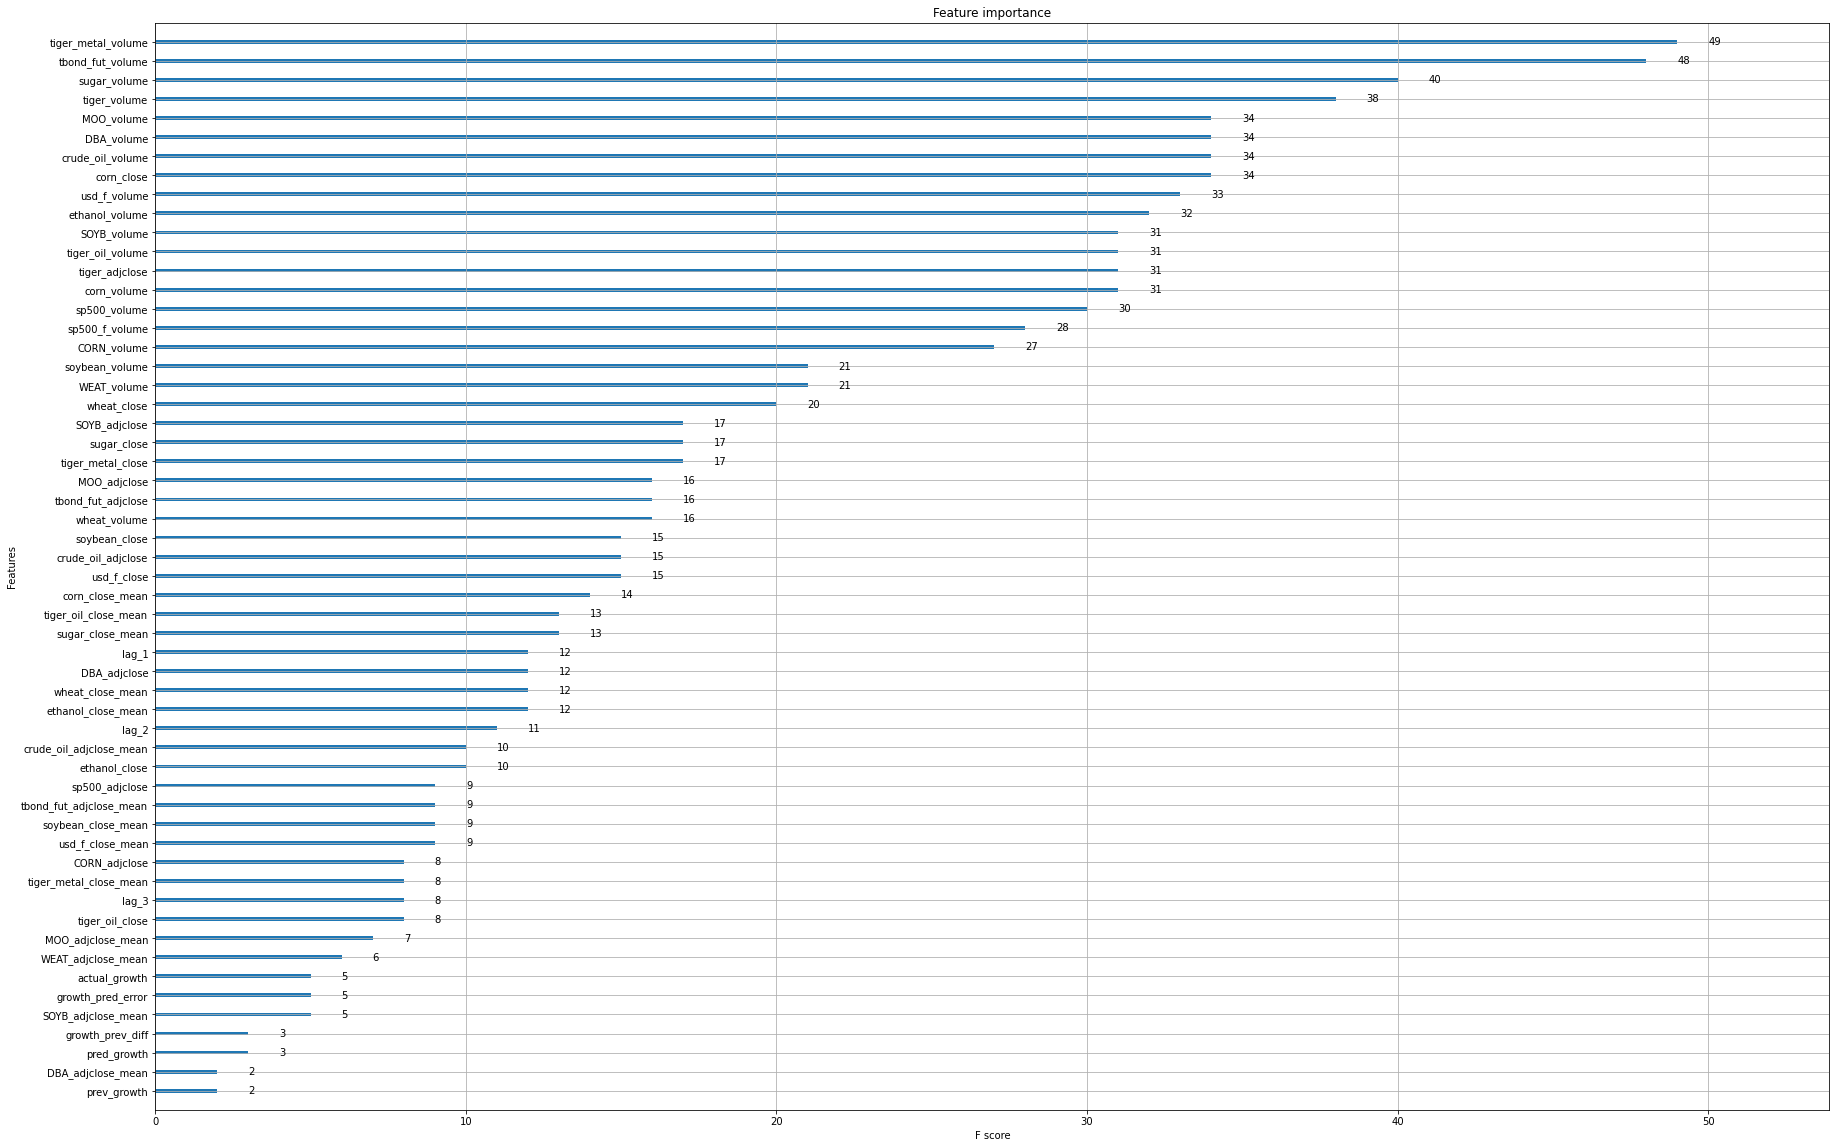

In [13]:
xg_model1=XGBClassifier()

xg_model1.fit(X_train_mod1, y_train_mod1,eval_set=[(X_valid_mod1, y_valid_mod1)], eval_metric='error',verbose= 100, early_stopping_rounds= 25)
preds_mod1 = xg_model1.predict(X_test_mod1)

print("Model F1 Score : ",f1_score(y_test_mod1, preds_mod1))
fig, ax = plt.subplots(1,1,figsize=(30,20))
plot_importance(xg_model1,ax=ax)

[0]	validation_0-error:0.42683


C:\Users\lsh\anaconda3\envs\ml4t\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lsh\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[47]	validation_0-error:0.35366
Model F1 Score :  0.6407185628742516


C:\Users\lsh\anaconda3\envs\ml4t\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

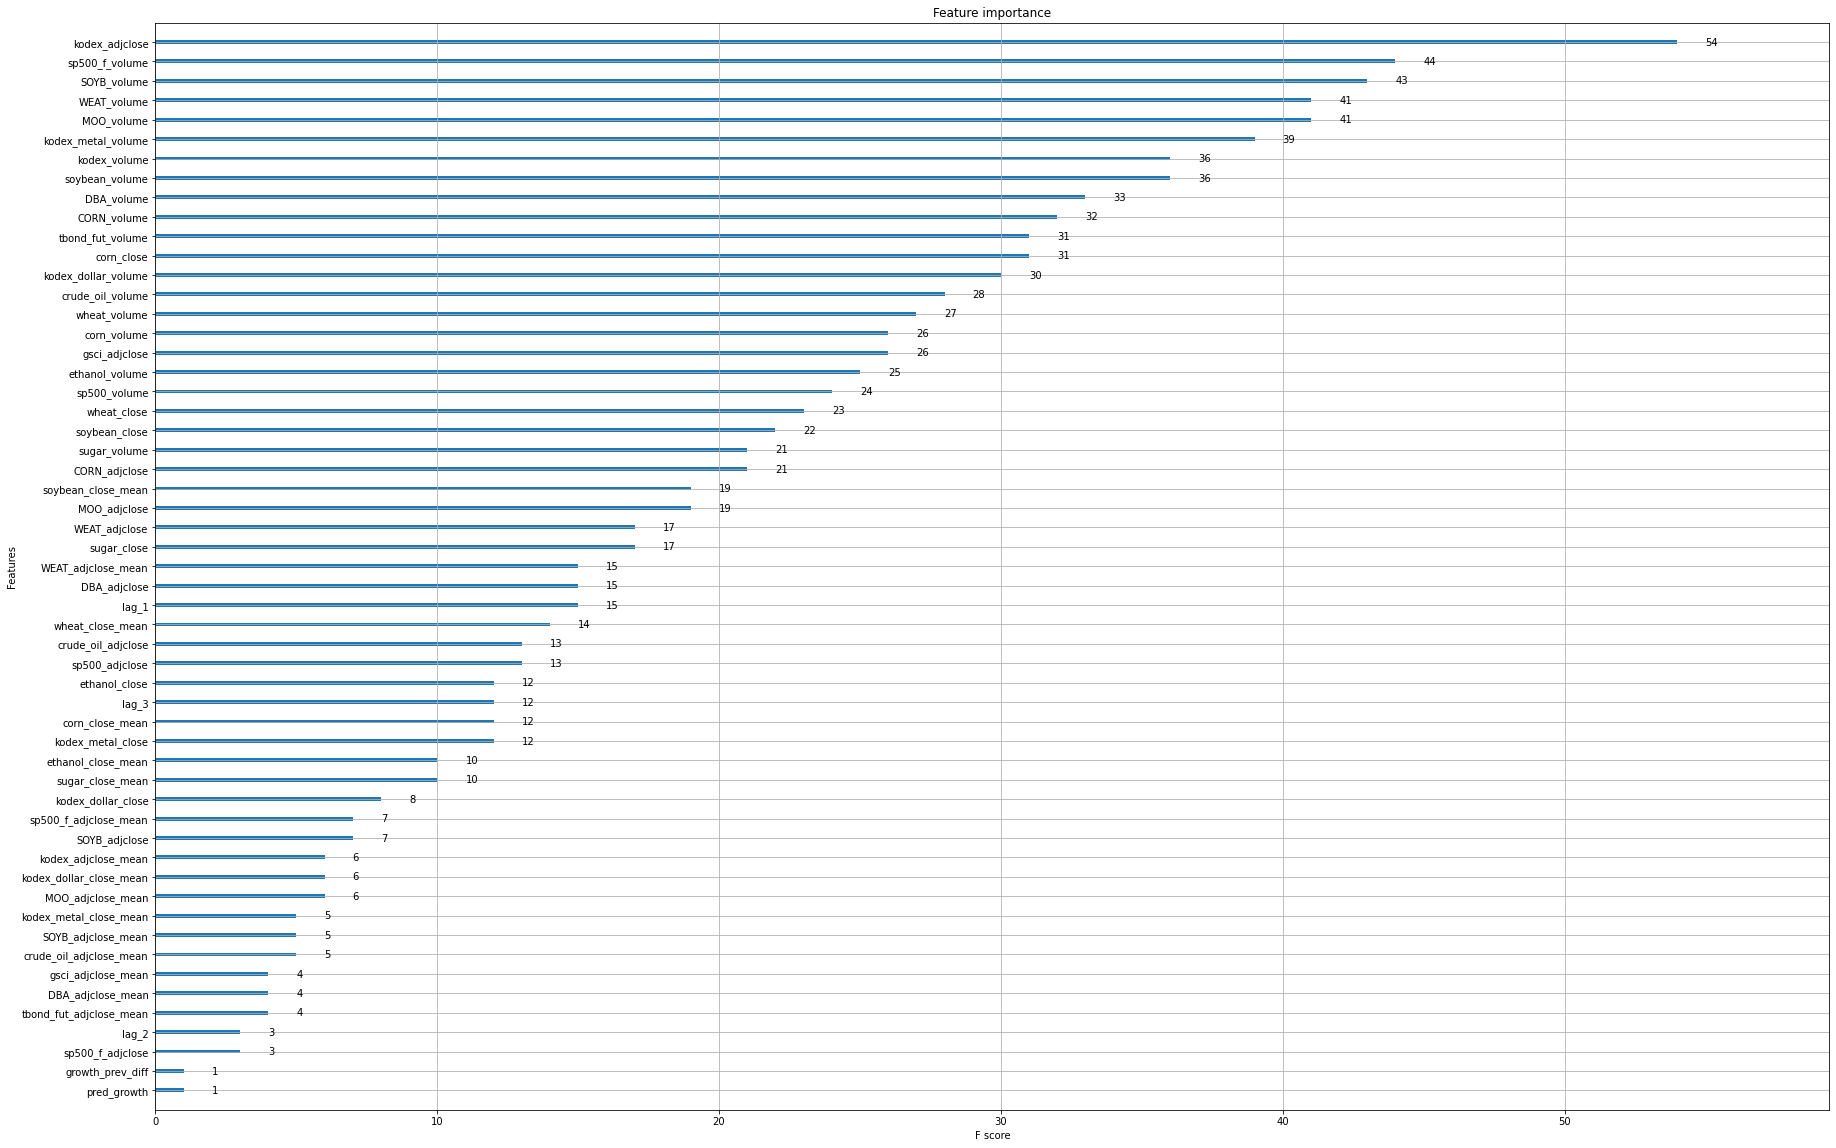

In [14]:

xg_model2=XGBClassifier()

xg_model2.fit(X_train_mod2, y_train_mod2,eval_set=[(X_valid_mod2, y_valid_mod2)], eval_metric='error',verbose= 100, early_stopping_rounds= 25)
preds_mod2 = xg_model2.predict(X_test_mod2)

print("Model F1 Score : ",f1_score(y_test_mod2, preds_mod2))
fig, ax = plt.subplots(1,1,figsize=(30,20))
plot_importance(xg_model2,ax=ax)